c:\users\zanta\anaconda3\envs\py3\lib\site-packages\tables\attributeset.py:308: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)


Text(0.5, 1.0, 'sum(axis=2)')

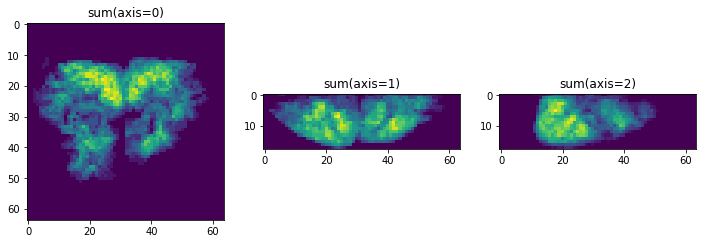

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from loaders import vim2

loader = vim2.Vim2()
mask = None
for k, v in loader._get_rois().items():
    if mask is None:
        mask = (v > 0)
    else:
        mask |= (v > 0)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mask.sum(axis=0))
plt.title('sum(axis=0)')

plt.subplot(132)
plt.imshow(mask.sum(axis=1))
plt.title('sum(axis=1)')

plt.subplot(133)
plt.imshow(mask.sum(axis=2))
plt.title('sum(axis=2)')

c:\users\zanta\anaconda3\envs\py3\lib\site-packages\tables\attributeset.py:308: DataTypeWarning: Unsupported type for attribute 'MATLAB_fields' in node 'roi'. Offending HDF5 class: 9
  value = self._g_getattr(self._v_node, name)
<ipython-input-11-a676f9082855>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, labels = torch.tensor(X, device=device), torch.tensor(labels, device=device)


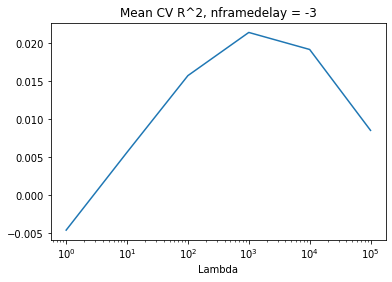

-3
tensor(0.1127)
tensor(0.1215)


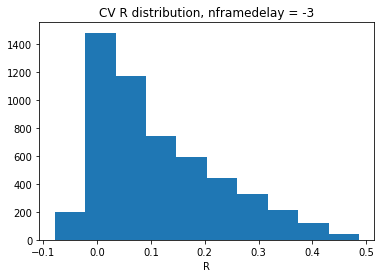

<ipython-input-11-a676f9082855>:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stim, labels = torch.tensor(stim, device=device), torch.tensor(labels, device=device)


Report
-3
tensor(0.2254)
tensor(0.3314)


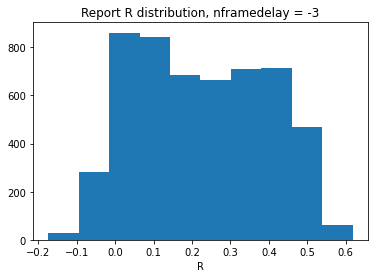

In [11]:
import collections
from python_dict_wrapper import wrap
import separable_net
import train_fmri
import os
import torch

def compute_corr(Yl, Yp):
    corr = torch.zeros(Yl.shape[1], device=Yl.device)
    for i in range(Yl.shape[1]):
        yl, yp = (Yl[:, i].cpu().detach().numpy(), 
                  Yp[:, i].cpu().detach().numpy())
        yl = yl[~np.isnan(yl)]
        yp = yp[~np.isnan(yp)]
        corr[i] = np.corrcoef(yl, yp)[0, 1]
    return corr

device = torch.device('cuda')

for nframedelay in [-3]:
    args = wrap({'data_root': 'data',
                 'target_layer': 'layer1'})
    
    trainset = vim2.Vim2(os.path.join(args.data_root, 'crcns-vim2'), 
                                split='traintune', 
                                nt=1, 
                                nx=112,
                                ny=112,
                                ntau=5, 
                                nframedelay=nframedelay)

    reportset = vim2.Vim2(os.path.join(args.data_root, 'crcns-vim2'), 
                                split='report', 
                                nt=1, 
                                nx=112,
                                ny=112,
                                ntau=5, 
                                nframedelay=nframedelay)
    
    trainloader = torch.utils.data.DataLoader(trainset, 
                                              batch_size=36, 
                                              shuffle=False,
                                              pin_memory=True
                                              )

    reportloader = torch.utils.data.DataLoader(reportset, 
                                             batch_size=36, 
                                             shuffle=False,
                                             pin_memory=True
                                             )

    feature_model, activations, sz, threed = train_fmri.get_model(args)

    feature_model.to(device=device)

    stims = []
    contrasts = []
    y = []
    for X, labels in trainloader:
        X, labels = torch.tensor(X, device=device), torch.tensor(labels, device=device)

        with torch.no_grad():
            result = feature_model(X)
            fit_layer = activations[args.target_layer]
            stim = fit_layer[:, :, 1:, :, :].mean(4).mean(3)
            stims.append(stim)
            y.append(labels.squeeze())

    stims = torch.cat(stims, axis=0)
    y = torch.cat(y, axis=0)

    X = ((stims.reshape((stims.shape[0], -1)) - 5) / 2.5).to(device='cpu')
    X = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
    y = y.to(device='cpu')

    lambdas = np.array([1, 10, 100, 1000, 10000, 100000])
    splits = (np.arange(X.shape[0]) / 100).astype(np.int) % 10

    y_preds = torch.zeros(y.shape[0], y.shape[1], len(lambdas))

    for i in range(10):
        X_train, y_train, X_test, y_test = X[splits != i, :], y[splits != i, :], X[splits == i, :], y[splits == i, :]
        for j, lambda_ in enumerate(lambdas):
            H = X_train.T.matmul(X_train) + lambda_ * torch.eye(X_train.shape[1])
            w = torch.inverse(H).matmul(X_train.T.matmul(y_train))
            y_pred = X_test.matmul(w)
            y_preds[splits == i, :, j] = y_pred
            
    var_baseline = ((y - y.mean(axis=0, keepdims=True)) ** 2).mean(0)
    var_after = ((y.reshape(y.shape[0], y.shape[1], 1) - y_preds) ** 2).mean(0)
    r2 = 1 - var_after / var_baseline.reshape((-1, 1))
    
    plt.semilogx(lambdas, r2.mean(axis=0))
    plt.xlabel('Lambda')
    plt.title(f'Mean CV R^2, nframedelay = {nframedelay}')
    plt.show()
    
    best_lambda_idx = r2.mean(axis=0).argmax()
    best_lambda = lambdas[best_lambda_idx]
    
    corrs = compute_corr(y, y_preds[:, :, best_lambda_idx])
    
    print(nframedelay)
    print(corrs.mean())
    print(corrs[0])
    
    corrs_cv = corrs

    plt.hist(corrs_cv.cpu().detach().numpy())
    plt.xlabel('R')
    plt.title(f'CV R distribution, nframedelay = {nframedelay}')
    plt.show()
    
    # Same thing, for report fold
    stims = []
    contrasts = []
    y_report = []
    for stim, labels in reportloader:
        stim, labels = torch.tensor(stim, device=device), torch.tensor(labels, device=device)

        with torch.no_grad():
            result = feature_model(stim)
            fit_layer = activations[args.target_layer]
            stim = fit_layer[:, :, 1:, :, :].mean(4).mean(3)
            stims.append(stim)
            y_report.append(labels.squeeze())

    stims_report = torch.cat(stims, axis=0)
    y_report = torch.cat(y_report, axis=0)

    # Use the same lambda for everyone.
    lambda_ = best_lambda

    X_report = ((stims_report.reshape((stims_report.shape[0], -1)) - 5) / 2.5).to(device='cpu')
    X_report = torch.cat([X_report, torch.ones(X_report.shape[0], 1)], dim=1)
    y_report = y_report.to(device='cpu')

    H = X.T.matmul(X) + lambda_ * torch.eye(X.shape[1])
    w = torch.inverse(H).matmul(X.T.matmul(y))
    y_pred = X_report.matmul(w)
    
    corrs = compute_corr(y_report, y_pred)

    print('Report')
    print(nframedelay)
    print(corrs.mean())
    print(corrs[0])
    
    plt.hist(corrs.cpu().detach().numpy())
    plt.xlabel('R')
    plt.title(f'Report R distribution, nframedelay = {nframedelay}')
    plt.show()

In [8]:
y_train.shape

torch.Size([6400, 1, 5320])

In [17]:
# How expensive is this
A = torch.randn(20000, 20000, device='cuda')
H = torch.matmul(A.T, A)
_ = torch.inverse(H)

In [137]:
feature_model.to(device=device)
subnet.to(device=device)



In [144]:
y_pred.std(axis=0).cpu().detach().numpy().mean()

0.15927128

array([[1.        , 0.33140899],
       [0.33140899, 1.        ]])

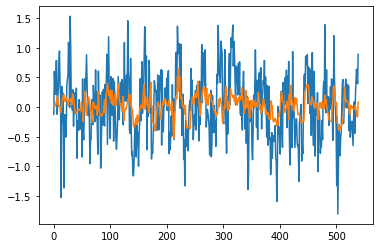

In [138]:
plt.plot(10 * y_report[:, 0])
plt.plot(y_pred[:, 0])
#r2[0]
np.corrcoef(y_report[:, 0], y_pred[:, 0])

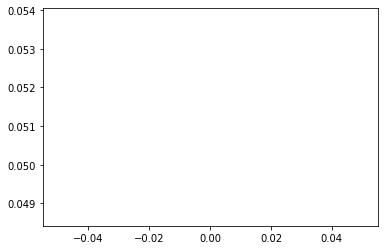

tensor(0.2263)


Text(0.5, 0, 'R2')

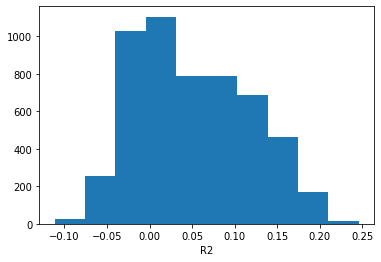

In [139]:
plt.plot(r2.mean(axis=0))
plt.show()
print(torch.sqrt(r2.mean(axis=0).max()))

plt.hist(r2.cpu().detach().numpy())
plt.xlabel('R2')

tensor(0.2535)

-4

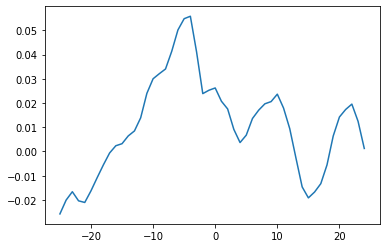

In [187]:
#plt.plot(contrasts.cpu().detach().numpy())
#plt.plot(2000*y.sum(axis=1).cpu().detach().numpy())

delays = np.arange(-25, 25)
delayed = []
for delay in delays:
    delayed.append(
        np.corrcoef(np.roll(y.sum(axis=1).cpu().detach().numpy(), delay), contrasts.cpu().detach().numpy())[0, 1]
    )
    
plt.plot(delays, delayed)
delays[np.argmax(delayed)]

In [194]:
delayed = np.array(delayed)
delayed[(delays > -10) & (delays <=0)]

array([0.03212755, 0.0340777 , 0.04136896, 0.05020479, 0.05484857,
       0.05586324, 0.04112504, 0.02390238, 0.02530659, 0.02623835])

In [132]:
fit_layer.shape

torch.Size([1, 60, 4, 112, 112])

In [130]:
from matplotlib import animation
from IPython.display import HTML

def get_anim(result, norm=False):
  fig = plt.figure(figsize=(4, 4))
  ax = plt.gca()
  im = plt.imshow([[1]])
  plt.axis('off')

  rg = None
  if norm:
    rg = [result.min(), result.max()]

  def drawframe(n):
      if n >= nt:
        n = nt - 1
      else:
        im.set_data(result[:, n, :, :].transpose((2, 1, 0)))
      if norm:
        im.set_clim(rg)
      return (im)

  # blit=True re-draws only the parts that have changed.
  nt = result.shape[1]
  anim = animation.FuncAnimation(fig, drawframe, frames=nt, interval=1000/15, blit=False)
  plt.close()
  return anim
HTML(get_anim(.5 + .1 *X.cpu().detach().numpy()).to_html5_video())

In [71]:
fit_layer[:3, :, :, :].shape

torch.Size([1, 60, 7, 112, 112])

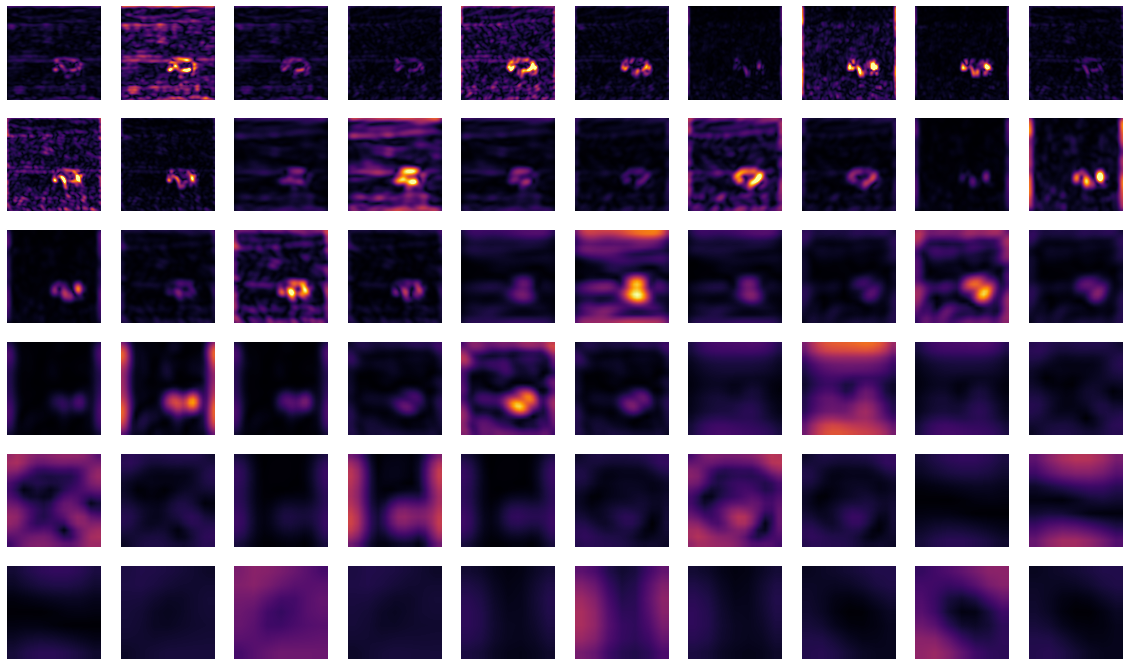

In [126]:
from matplotlib import animation
from IPython.display import HTML

"""
def get_anim(result, norm=False):
  fig = plt.figure(figsize=(4, 4))
  ax = plt.gca()
  im = plt.imshow([[1]])
  plt.axis('off')

  rg = None
  if norm:
    rg = [result.min(), result.max()]

  def drawframe(n):
      if n >= nt:
        n = nt - 1
      else:
        im.set_data(result[:, n, :, :].transpose((2, 1, 0)))
      if norm:
        im.set_clim(rg)
      return (im)

  # blit=True re-draws only the parts that have changed.
  nt = result.shape[1]
  anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=1000/15, blit=False)
  plt.close()
  return anim
"""
plt.figure(figsize=(20, 12))
for i in range(60):
    plt.subplot(6, 10, i+1)
    #HTML(get_anim(.5 + .01 *fit_layer[0, i, 0, :, :].cpu().detach().numpy()).to_html5_video())
    plt.imshow((fit_layer[0, i, -3, :, :].cpu().detach().numpy()).T, clim=[0, 20], cmap='inferno')
    plt.axis('off')

In [93]:
fit_layer.max()

tensor(87.1931, device='cuda:0')

In [6]:
mask.shape

(18, 64, 64)

In [37]:
len(loader.sequence)

1782

In [2]:
loader = vim2.Vim2(split='report')

d = 0
i = 0

for _, slc in loader:
    if i % 1000 == 0:
        print(i)
    d += (~np.isnan(slc)).sum(axis=0)
    i += 1

0


KeyboardInterrupt: 

In [7]:
slc.std()

0.065692715

In [15]:
loader._get_rois().keys()

dict_keys(['FFAlh', 'FFArh', 'IPlh', 'IPrh', 'MTlh', 'MTplh', 'MTprh', 'MTrh', 'OBJlh', 'OBJrh', 'PPAlh', 'PPArh', 'RSCrh', 'STSrh', 'VOlh', 'VOrh', 'latocclh', 'latoccrh', 'v1lh', 'v1rh', 'v2lh', 'v2rh', 'v3alh', 'v3arh', 'v3blh', 'v3brh', 'v3lh', 'v3rh', 'v4lh', 'v4rh'])

(array([ 32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 165.]),
 array([  0. ,  63.2, 126.4, 189.6, 252.8, 316. , 379.2, 442.4, 505.6,
        568.8, 632. ]),
 <BarContainer object of 10 artists>)

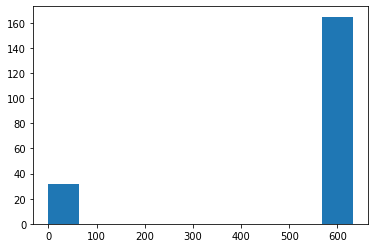

In [45]:
plt.hist(d[(loader._get_rois()['MTlh'] > 0).ravel()].ravel())

In [42]:
plt.imshow(volume

(18, 64, 64)

Text(0.5, 1.0, 'sum(axis=2)')

<Figure size 432x288 with 0 Axes>

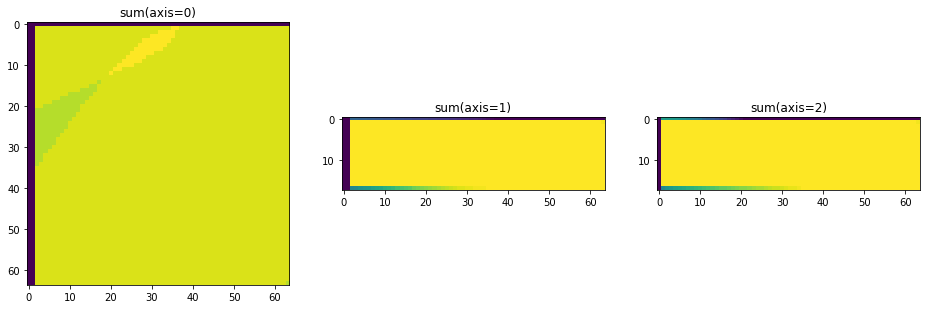

<Figure size 432x288 with 0 Axes>

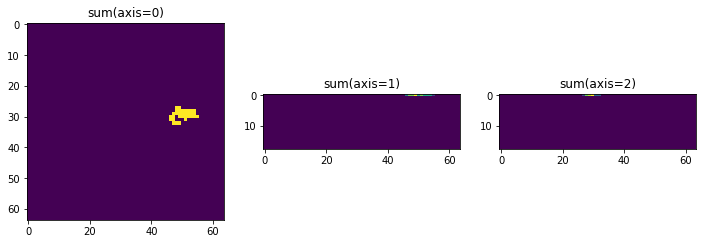

In [53]:
X, Y = loader[0]
dims = (18, 64, 64)
valid_volume = (~np.isnan(Y)).any(axis=0).reshape(dims)
localizer = (loader._get_rois()['MTlh'] > 0).reshape(dims)
volume = valid_volume# & localizer
rejected_volume = ~valid_volume & localizer


plt.figure()
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.imshow(volume.sum(axis=0))
plt.title('sum(axis=0)')

plt.subplot(132)
plt.imshow(volume.sum(axis=1))
plt.title('sum(axis=1)')

plt.subplot(133)
plt.imshow(volume.sum(axis=2))
plt.title('sum(axis=2)')

plt.figure()
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(rejected_volume.sum(axis=0))
plt.title('sum(axis=0)')

plt.subplot(132)
plt.imshow(rejected_volume.sum(axis=1))
plt.title('sum(axis=1)')

plt.subplot(133)
plt.imshow(rejected_volume.sum(axis=2))
plt.title('sum(axis=2)')

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 17, ..., 17, 17, 17],
       [ 0,  0, 17, ..., 17, 17, 17],
       ...,
       [ 0,  0, 17, ..., 17, 17, 17],
       [ 0,  0, 17, ..., 17, 17, 17],
       [ 0,  0, 17, ..., 17, 17, 16]])